# 201810808 정민지

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

## 문제 1 : 2020년 8월 서울시 지하철호선별 역별 승하차 인원 정보


'서울시 지하철호선별 역별 승하차 인원 정보'를 검색하거나,

https://data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do

사이트를 방문한다. 분석할 파일은 'CARD_SUBWAY_MONTH_202008.csv'이다.

### 1-1) DataFrame 생성하고, 스키마는 자동인식하여 출력

In [2]:
_subway = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/CARD_SUBWAY_MONTH_202008.csv')

#### 답

In [3]:
_subway.printSchema()

root
 |-- 사용일자: integer (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역ID: string (nullable = true)
 |-- 역명: integer (nullable = true)
 |-- 승차총승객수: integer (nullable = true)
 |-- 하차총승객수: integer (nullable = true)
 |-- 등록일자: string (nullable = true)



### 1-2) 컬럼명을 변경하고, 스키마 출력

In [4]:
subway=_subway\
    .withColumnRenamed("사용일자", "dataUse")\
    .withColumnRenamed("노선명", "line")\
    .withColumnRenamed("역ID", "stationID")\
    .withColumnRenamed("역명", "station")\
    .withColumnRenamed("승차총승객수", "NInPassengers")\
    .withColumnRenamed("하차총승객수", "NOutPassengers")\
    .withColumnRenamed("등록일자", "dateRegi")

#### 답

In [5]:
subway.printSchema()

root
 |-- dataUse: integer (nullable = true)
 |-- line: string (nullable = true)
 |-- stationID: string (nullable = true)
 |-- station: integer (nullable = true)
 |-- NInPassengers: integer (nullable = true)
 |-- NOutPassengers: integer (nullable = true)
 |-- dateRegi: string (nullable = true)



### 1-3) 노선별 승하차합계가 가장 높은 역을 출력 (모든 노선 출력)

#### 역별 승하차 합계 컬럼 생성

In [6]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
sum_columns = F.udf(lambda x,y: x+y,IntegerType())

In [7]:
subway=subway.withColumn("SumInOut", sum_columns('NInPassengers','NOutPassengers'))

#### 노선별 승하차 합계가 가장 높은 역 출력

In [8]:
from pyspark.sql.window import Window
win = Window.partitionBy("line").orderBy(F.col("SumInOut").desc()) # line기준 SumInOut 많은것부터 count

#### 답

In [9]:
from pyspark.sql.functions import row_number
subway_rank=subway.withColumn("rank", row_number().over(win))
subway_rank.filter(subway_rank.rank==1).show(27)

+--------+--------------+--------------------+-------+-------------+--------------+--------+--------+----+
| dataUse|          line|           stationID|station|NInPassengers|NOutPassengers|dateRegi|SumInOut|rank|
+--------+--------------+--------------------+-------+-------------+--------------+--------+--------+----+
|20200807|        일산선|                화정|  17591|        17916|      20200810|    null|20218726|   1|
|20200814|        장항선|            온양온천|   4528|         4534|      20200817|    null|20205351|   1|
|20200807|        경부선|              영등포|  43168|        46982|      20200810|    null|20247792|   1|
|20200812|    우이신설선|        북한산보국문|   5432|         5200|      20200815|    null|20206015|   1|
|20200814|        분당선|                야탑|  25876|        27587|      20200817|    null|20228404|   1|
|20200812|         7호선|      가산디지털단지|  46117|        46836|      20200815|    null|20247651|   1|
|20200812|        수인선|            인천논현|   5428|         5761|      20200815|    

### 1-4) 노선별 요일별 승하차인원 합계 (모든 노선 출력)

In [10]:
# DATE 형식으로 바꾸기 위함
toDate = F.udf(lambda x: str(x)[0:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])

In [11]:
subway=subway.withColumn("date",toDate(subway.dataUse))

In [12]:
subway=subway.withColumn("Day",F.dayofweek("date")) # 1: 일요일, 2: 월요일... 7:토요일

In [13]:
from pyspark.sql.types import StringType
def dateToStr(x):
    q=""
    if x==1:
        q="Sunday"
    elif x==2:
        q="Monday"
    elif x==3:
        q="Tuesday"
    elif x==4:
        q="Wednesday"
    elif x==5:
        q="Thursday"
    elif x==6:
        q="Friday"
    elif x==7:
        q="Saturday"
    else:
        q="error!"
    return q

In [14]:
dateToStr_udf=F.udf(dateToStr,StringType())

In [15]:
# 숫자로 되어있던 요일을 String으로
subway=subway.withColumn("Day",dateToStr_udf('Day'))

In [16]:
dayCount=subway.groupby('line').pivot('Day').agg({"SumInOut":"sum"})

#### 답

In [17]:
dayCount.show(27)

+--------------+----------+----------+----------+----------+----------+----------+----------+
|          line|    Friday|    Monday|  Saturday|    Sunday|  Thursday|   Tuesday| Wednesday|
+--------------+----------+----------+----------+----------+----------+----------+----------+
|        일산선| 808395124|1010437381|1010319451|1010235636| 808383940| 808393127| 808392796|
|        장항선| 484860929| 606069487| 606063946| 606058420| 484854907| 484857571| 484857468|
|        경부선|3152874143|3940824196|3940449561|3940133615|3152768029|3152789327|3152794978|
|    우이신설선|1050583774|1313216004|1313167396|1313141053|1050582715|1050586483|1050587942|
|        분당선|2809238836|3435543817|3455281248|3434771069|2788970586|2789009658|2768803828|
|         7호선|4123433410|5153934706|5152897879|5152372864|4123394044|4123436711|4123433745|
|        수인선|1050588760|1313214661|1313171127|1313138823|1050582601|1050584965|1050586007|
|        안산선|1050846248|1313503526|1313393601|1313300973|1050826620|1050840359|105

### 1- 5) 노선별 요일별 승하차인원 그래프

In [18]:
import pandas as pd
subwayP=dayCount.toPandas() #그래프 그리기 위해 pandas로

In [19]:
subwayP=subwayP.set_index('line') #index가 자동으로 0~이런식으로 설정되어서 line을 index로 변경

In [20]:
my=subwayP.transpose()

In [21]:
my

line,일산선,장항선,경부선,우이신설선,분당선,7호선,수인선,안산선,4호선,1호선,...,6호선,5호선,8호선,과천선,경인선,중앙선,9호선2~3단계,2호선,공항철도 1호선,경원선
Friday,808395124,484860929,3152874143,1050583774,2809238836,4123433410,1050588760,1050846248,2102629179,808840770,...,3031250674,4244326342,1374322875,646761679,1617072711,1697177179,1050770990,4045276621,1131557563,2384370698
Monday,1010437381,606069487,3940824196,1313216004,3435543817,5153934706,1313214661,1313503526,2627972877,1010902468,...,3798984557,5315167094,1717805968,808392943,2021192027,2121432133,1313402811,5055626768,1414390988,2970260113
Saturday,1010319451,606063946,3940449561,1313167396,3455281248,5152897879,1313171127,1313393601,2627425802,1010677910,...,3798594037,5314273162,1717544282,808256281,2020923212,2121354249,1313272640,5053793274,1414297414,2949914423
Sunday,1010235636,606058420,3940133615,1313141053,3434771069,5152372864,1313138823,1313300973,2627003684,1010442174,...,3818552063,5313799053,1717409954,808185423,2020665884,2121287666,1313206990,5052610742,1414249246,2929559913
Thursday,808383940,484854907,3152768029,1050582715,2788970586,4123394044,1050582601,1050826620,2102581482,808804370,...,3091829677,4244300204,1374304672,646752103,1617026950,1697164041,1050763509,4045136758,1131545840,2343934038
Tuesday,808393127,484857571,3152789327,1050586483,2789009658,4123436711,1050584965,1050840359,2102588996,808813210,...,3031240634,4244334032,1374321055,646758203,1617048535,1697169680,1050766410,4045209970,1131547289,2343944193
Wednesday,808392796,484857468,3152794978,1050587942,2768803828,4123433745,1050586007,1050838751,2102590630,808797690,...,3031242266,4244325671,1374320670,646760792,1617052844,1697166980,1050767248,4045204601,1131542158,2364136818


In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [23]:
from matplotlib import rc, font_manager
rc('font',family="NanumGothic")

#길이 옆으로 늘리기
plt.rcParams["figure.figsize"] = (15,10)

#격자
plt.rcParams['axes.grid'] = True

#두께
plt.rcParams['lines.linewidth'] = 2

#### 답

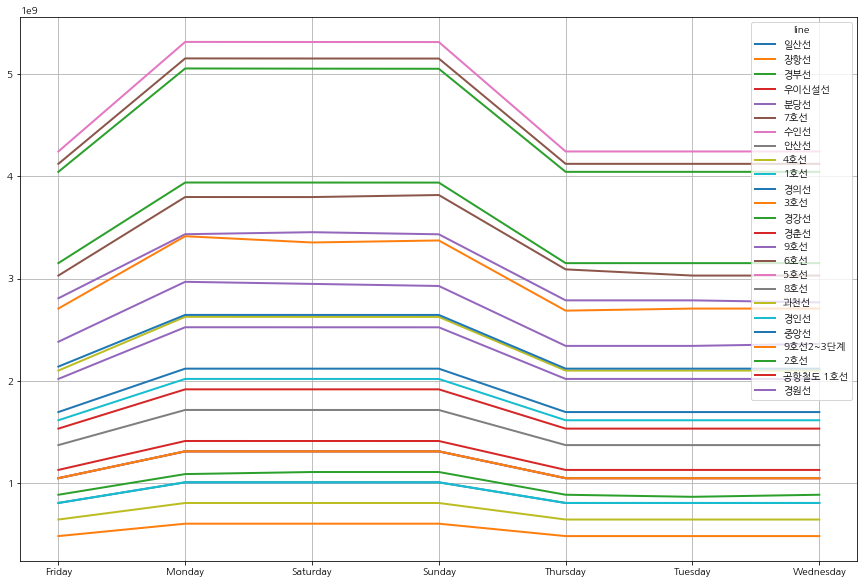

In [24]:
my.plot(kind='line') #y축이 단위가 1e9이다!

---
---
## 문제 2 : 한국의 코로나바이러스
데이터는 TimeProvince.csv를 다운로드해서 사용한다.

### 2-1) DataFrame 생성하고, 자동인식한 스키마를 출력

In [25]:
covid = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/TimeProvince.csv')

#### 답

In [26]:
covid.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- province: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- released: integer (nullable = true)
 |-- deceased: integer (nullable = true)



### 2-2) 3월의 데이터만 출력

#### 답

In [27]:
covid.filter(F.month('date')=="03").show()

+----------+----+-----------------+---------+--------+--------+
|      date|time|         province|confirmed|released|deceased|
+----------+----+-----------------+---------+--------+--------+
|2020-03-01|  16|            Seoul|       87|      11|       0|
|2020-03-01|  16|            Busan|       83|       0|       0|
|2020-03-01|  16|            Daegu|     2704|       6|      11|
|2020-03-01|  16|          Incheon|        6|       1|       0|
|2020-03-01|  16|          Gwangju|        9|       2|       0|
|2020-03-01|  16|          Daejeon|       13|       0|       0|
|2020-03-01|  16|            Ulsan|       20|       0|       0|
|2020-03-01|  16|           Sejong|        1|       0|       0|
|2020-03-01|  16|      Gyeonggi-do|       89|       8|       1|
|2020-03-01|  16|       Gangwon-do|       15|       0|       0|
|2020-03-01|  16|Chungcheongbuk-do|       11|       0|       0|
|2020-03-01|  16|Chungcheongnam-do|       68|       0|       0|
|2020-03-01|  16|     Jeollabuk-do|     

### 2-3) 년x월별 건수

In [28]:
covid_ym=covid\
        .withColumn("year",F.year('date'))\
        .withColumn("month",F.month('date'))

#### 답

In [29]:
covid_ym.groupBy('year').pivot('month').count().show()

+----+---+---+---+---+---+---+
|year|  1|  2|  3|  4|  5|  6|
+----+---+---+---+---+---+---+
|2020|204|493|527|510|527|510|
+----+---+---+---+---+---+---+



### 2-4) 도별 첫 확진자 출현 (모든 도 출력)

In [30]:
# 처음 등장을 찾기 위해 confirmed가 0이 아닌 dataframe 만들기

covid2=covid.filter(covid.confirmed!=0)

In [31]:
covid2.show()

+----------+----+-----------+---------+--------+--------+
|      date|time|   province|confirmed|released|deceased|
+----------+----+-----------+---------+--------+--------+
|2020-01-20|  16|    Incheon|        1|       0|       0|
|2020-01-21|  16|    Incheon|        1|       0|       0|
|2020-01-22|  16|    Incheon|        1|       0|       0|
|2020-01-23|  16|    Incheon|        1|       0|       0|
|2020-01-24|  16|    Incheon|        1|       0|       0|
|2020-01-24|  16|Gyeonggi-do|        1|       0|       0|
|2020-01-25|  16|    Incheon|        1|       0|       0|
|2020-01-25|  16|Gyeonggi-do|        1|       0|       0|
|2020-01-26|  16|    Incheon|        1|       0|       0|
|2020-01-26|  16|Gyeonggi-do|        2|       0|       0|
|2020-01-27|  16|      Seoul|        1|       0|       0|
|2020-01-27|  16|    Incheon|        1|       0|       0|
|2020-01-27|  16|Gyeonggi-do|        2|       0|       0|
|2020-01-28|  16|      Seoul|        1|       0|       0|
|2020-01-28|  

In [32]:
win2 = Window.partitionBy("province").orderBy("confirmed")

In [33]:
# 등장 순서대로 count
covid_cho=covid2.withColumn("chronological", row_number().over(win2))

#### 답

In [34]:
covid_cho.filter(covid_cho.chronological==1).show()

+----------+----+-----------------+---------+--------+--------+-------------+
|      date|time|         province|confirmed|released|deceased|chronological|
+----------+----+-----------------+---------+--------+--------+-------------+
|2020-02-22|  16|           Sejong|        1|       0|       0|            1|
|2020-02-22|  16|            Ulsan|        1|       0|       0|            1|
|2020-02-21|  16|Chungcheongbuk-do|        1|       0|       0|            1|
|2020-02-22|  16|       Gangwon-do|        6|       0|       0|            1|
|2020-02-04|  16|          Gwangju|        1|       0|       0|            1|
|2020-02-19|  16| Gyeongsangbuk-do|        2|       1|       0|            1|
|2020-02-18|  16|            Daegu|        1|       0|       0|            1|
|2020-02-19|  16| Gyeongsangnam-do|        3|       0|       0|            1|
|2020-01-20|  16|          Incheon|        1|       0|       0|            1|
|2020-02-21|  16|          Jeju-do|        1|       0|       0| 

### 2-5) 도별 누적 확진자 (마지막 일 6월 30일 기준, 모든 도 출력)

In [35]:
winAgg  = Window.partitionBy("province")

In [36]:
covid_sum=covid.withColumn("cumulative_confirmed",F.sum(F.col("confirmed")).over(winAgg))

#### 답

In [37]:
covid_sum.filter(covid.date=="2020-06-30").show()

+----------+----+-----------------+---------+--------+--------+--------------------+
|      date|time|         province|confirmed|released|deceased|cumulative_confirmed|
+----------+----+-----------------+---------+--------+--------+--------------------+
|2020-06-30|   0|           Sejong|       50|      47|       0|                5111|
|2020-06-30|   0|            Ulsan|       55|      50|       1|                5269|
|2020-06-30|   0|Chungcheongbuk-do|       65|      60|       0|                5801|
|2020-06-30|   0|       Gangwon-do|       65|      54|       3|                5908|
|2020-06-30|   0|          Gwangju|       44|      32|       0|                3359|
|2020-06-30|   0| Gyeongsangbuk-do|     1389|    1328|      54|              161079|
|2020-06-30|   0|            Daegu|     6906|    6700|     189|              807506|
|2020-06-30|   0| Gyeongsangnam-do|      134|     128|       0|               13860|
|2020-06-30|   0|          Incheon|      341|     290|       1|  

---
---
## 문제 3 : 키, 몸무게 상관관계
```ds4_spark_df, S.4.5 tsv 파일 읽기```에서 사용했던 ```ds_spark_heightweight.txt``` 파일을 사용한다.

### 3-1) DataFrame 생성하고, 스키마를 출력

* 컬럼명 id, **height(Inches), weight(Pounds)**

In [38]:
import os
heightweight = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))\
    .withColumnRenamed("_c0", "id")\
    .withColumnRenamed("_c1", "height")\
    .withColumnRenamed("_c2", "weight")

#### 답

In [39]:
heightweight.printSchema()

root
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



### 3-2) BMI 컬럼 생성

BMI는 wikipedia를 참고하여 계산  

- BMI= $\frac{w}{t^2}$ 이고 이때 w는 체중(kg단위), t는 키(m단위) 이다.
- 위의 식에 **703을 곱해주면** 파운드와 인치를 사용하여 구한 BMI가 계산된다.


In [40]:
heightweight.show()

+---+------+------+
| id|height|weight|
+---+------+------+
|  1| 65.78|112.99|
|  2| 71.52|136.49|
|  3|  69.4|153.03|
|  4| 68.22|142.34|
|  5| 67.79| 144.3|
|  6|  68.7| 123.3|
|  7|  69.8|141.49|
|  8| 70.01|136.46|
|  9|  67.9|112.37|
| 10| 66.78|120.67|
| 11| 66.49|127.45|
| 12| 67.62|114.14|
| 13|  68.3|125.61|
| 14| 67.12|122.46|
| 15| 68.28|116.09|
| 16| 71.09| 140.0|
| 17| 66.46| 129.5|
| 18| 68.65|142.97|
| 19| 71.23| 137.9|
| 20| 67.13|124.04|
+---+------+------+
only showing top 20 rows



In [41]:
bmiUdf = F.udf(lambda x,y: float(x/(y*y)*703))

In [42]:
heightweight=heightweight.withColumn('bmi',bmiUdf('weight','height'))

#### 답

In [43]:
heightweight.show()

+---+------+------+------------------+
| id|height|weight|               bmi|
+---+------+------+------------------+
|  1| 65.78|112.99|18.357248855814564|
|  2| 71.52|136.49| 18.75863128975672|
|  3|  69.4|153.03|22.336388891195835|
|  4| 68.22|142.34| 21.50100976190556|
|  5| 67.79| 144.3|22.074475244077117|
|  6|  68.7| 123.3|18.365591807936536|
|  7|  69.8|141.49|20.415979753860807|
|  8| 70.01|136.46|19.572240185003462|
|  9|  67.9|112.37|  17.1342917441182|
| 10| 66.78|120.67|19.022246637140938|
| 11| 66.49|127.45|20.266674803735995|
| 12| 67.62|114.14|  17.5486155780677|
| 13|  68.3|125.61|18.929456000034303|
| 14| 67.12|122.46|19.109339862001555|
| 15| 68.28|116.09| 17.50504015479182|
| 16| 71.09| 140.0| 19.47450072154786|
| 17| 66.46| 129.5|  20.6112542018989|
| 18| 68.65|142.97|21.326478983666362|
| 19| 71.23| 137.9|19.107052746323113|
| 20| 67.13|124.04|19.350125594790867|
+---+------+------+------------------+
only showing top 20 rows



### 3-3) weigth와 height의 Zscore 컬럼 생성

In [44]:
# zscore 계산위해서 평균, 표준편차 필요
cal_meanstd = heightweight.select(
    F.mean('height').alias('mean_h'),
    F.stddev('height').alias('std_h'),
    F.mean('weight').alias('mean_w'),
    F.stddev('weight').alias('std_w')
).collect()

In [45]:
mean_h=cal_meanstd[0][0]
std_h=cal_meanstd[0][1]
mean_w=cal_meanstd[0][2]
std_w=cal_meanstd[0][3]

In [46]:
from pyspark.sql.types import DoubleType
zscoreUdfH = F.udf(lambda x: (x-mean_h)/std_h,DoubleType())
zscoreUdfW = F.udf(lambda x: (x-mean_w)/std_w,DoubleType())

In [47]:
heightweight=heightweight\
            .withColumn('zscoreH',zscoreUdfH('height'))\
            .withColumn('zscoreW',zscoreUdfW('weight'))

#### 답

In [48]:
heightweight.show()

+---+------+------+------------------+--------------------+--------------------+
| id|height|weight|               bmi|             zscoreH|             zscoreW|
+---+------+------+------------------+--------------------+--------------------+
|  1| 65.78|112.99|18.357248855814564| -1.2458467531235724| -1.2298965504184058|
|  2| 71.52|136.49| 18.75863128975672|  1.9011169693413281|  0.5933793097148594|
|  3|  69.4|153.03|22.336388891195835|  0.7388237478037734|    1.87665517042142|
|  4| 68.22|142.34| 21.50100976190556| 0.09188695468380685|  1.0472586195778204|
|  5| 67.79| 144.3|22.074475244077117|-0.14386119874126027|  1.1993275849336167|
|  6|  68.7| 123.3|18.365591807936536| 0.35504768408853965|-0.42998275816419484|
|  7|  69.8|141.49|20.415979753860807|  0.9581243556410441|  0.9813103437857668|
|  8| 70.01|136.46|19.572240185003462|   1.073257174755618|  0.5910517235104339|
|  9|  67.9|112.37|  17.1342917441182|-0.08355353158600981| -1.2779999986431976|
| 10| 66.78|120.67|19.022246

### 3-4) spark에서 위에 계산한 zscore를 사용하여 상관관계 계산

#### 답

In [49]:
print ("correlation: ",heightweight.stat.corr('zscoreH', 'zscoreW'))

correlation:  0.5925221289063219


### 3-5) scipy를 사용하여 상관관계를 계산

In [50]:
# height와 weight를 배열로 저장
H=heightweight.rdd.map(lambda x:float(x[1])).collect()
W=heightweight.rdd.map(lambda x:float(x[2])).collect()

In [51]:
import scipy.stats as stats

#### 답

In [52]:
# 정규분포일 때  ## spark로 계산시 이 값에 좀 더 가깝다!
stats.pearsonr(H,W)

(0.5925221289063218, 5.808558311242065e-06)

In [53]:
# 정규분포 아닐 때
stats.spearmanr(H,W)

SpearmanrResult(correlation=0.5261110712457925, pvalue=8.707798759901837e-05)